# Anomaly Detection Practical Overview

`machine_temperature_system_failure.csv`: Temperature sensor data of an internal component of a large, indiustrial machine. The second anomaly is difficult to detect and directly led to the third anomaly, a catastrophic failure of the machine.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

import pandas_profiling
from datetime import datetime

In [17]:
data = pd.read_csv("../results/numenta/realKnownCause/numenta_machine_temperature_system_failure.csv", sep=",", parse_dates=['timestamp'])
data.set_index('timestamp', inplace=True)
data.shape

(22695, 7)

In [18]:
data.head()

,value,anomaly_score,raw_score,label,S(t)_reward_low_FP_rate,S(t)_reward_low_FN_rate,S(t)_standard
timestamp,,,,,,,
2013-12-02 21:15:00,73.967322,0.030103,1.000,0,0.0,0.0,0.0
2013-12-02 21:20:00,74.935882,0.030103,1.000,0,0.0,0.0,0.0
2013-12-02 21:25:00,76.124162,1.000000,1.000,0,0.0,0.0,0.0
2013-12-02 21:30:00,78.140707,1.000000,0.500,0,0.0,0.0,0.0
2013-12-02 21:35:00,79.329836,1.000000,0.225,0,0.0,0.0,0.0


In [19]:
data.tail()

,value,anomaly_score,raw_score,label,S(t)_reward_low_FP_rate,S(t)_reward_low_FN_rate,S(t)_standard
timestamp,,,,,,,
2014-02-19 15:05:00,98.185415,0.138059,0.0,0,0.0,0.0,0.0
2014-02-19 15:10:00,97.804168,0.138059,0.0,0,0.0,0.0,0.0
2014-02-19 15:15:00,97.135468,0.138059,0.0,0,0.0,0.0,0.0
2014-02-19 15:20:00,98.056852,0.138059,0.0,0,0.0,0.0,0.0
2014-02-19 15:25:00,96.903861,0.138059,0.0,0,0.0,0.0,0.0


Observations have 5min gap, for ca. 2,5 month.

**raw_score**: anomaly score  
**anomaly_score**: LH score  
**label**: groundtruth, `1` if anomaly, `0` otherwise

In [33]:
data.describe()

,value,anomaly_score,raw_score,label,S(t)_reward_low_FP_rate,S(t)_reward_low_FN_rate,S(t)_standard
count,22695.000000,22695.000000,22695.000000,22695.000000,22695.000000,22695.000000,22695.000000
mean,85.926498,0.100219,0.005734,0.099934,0.000091,0.000120,0.000120
std,13.746912,0.049843,0.035088,0.299918,0.011899,0.011489,0.011489
min,2.084721,0.030103,0.000000,0.000000,-0.220000,-0.110000,-0.110000
25%,83.080078,0.071598,0.000000,0.000000,0.000000,0.000000,0.000000
50%,89.408246,0.090436,0.000000,0.000000,0.000000,0.000000,0.000000
75%,94.016252,0.138059,0.000000,0.000000,0.000000,0.000000,0.000000
max,108.510543,1.000000,1.000000,1.000000,0.999015,0.999015,0.999015


## Exploring our Time Series

In [34]:
ts = pd.Series(data.value)

In [35]:
pandas_profiling.ProfileReport(data)

Number of variables,8
Number of observations,22695
Total Missing (%),0.0%
Total size in memory,1.4 MiB
Average record size in memory,64.0 B
Numeric,4
Categorical,0
Boolean,1
Date,1
Text (Unique),0
Rejected,2


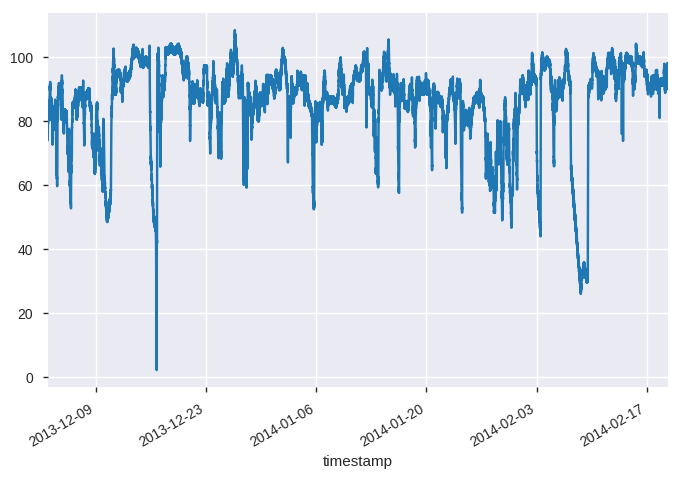

In [38]:
ts.plot()
# fig, ax = plt.subplots() #figsize=(15,7)
# ts.plot(ax=ax)

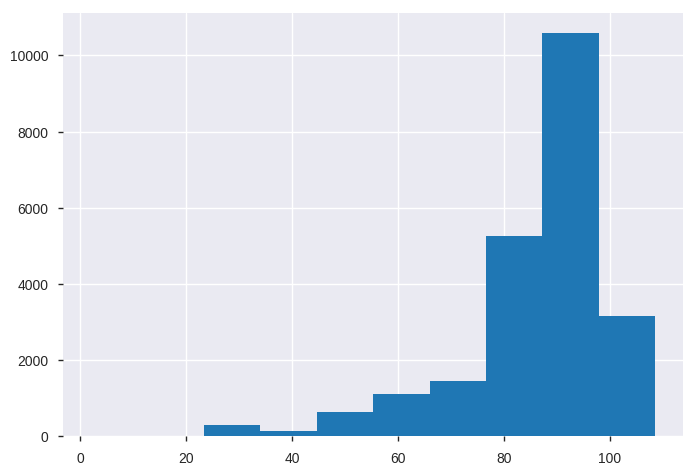

In [39]:
ts.hist()

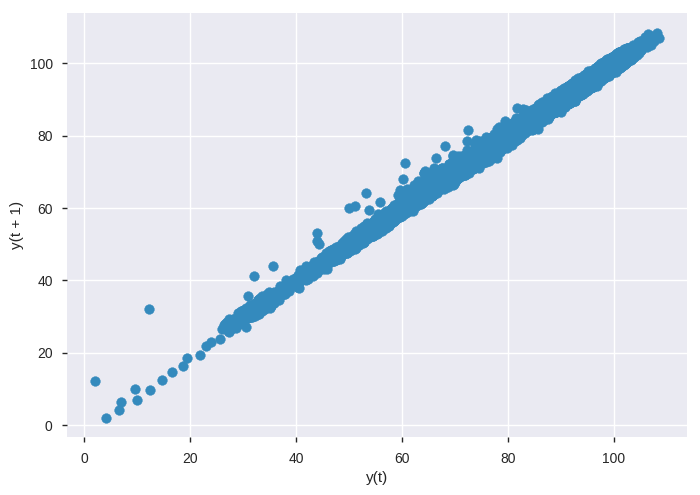

In [40]:
from pandas.plotting import lag_plot
lag_plot(ts)

**Correlation between observations and their lag1 values**: observations are positively correlated.

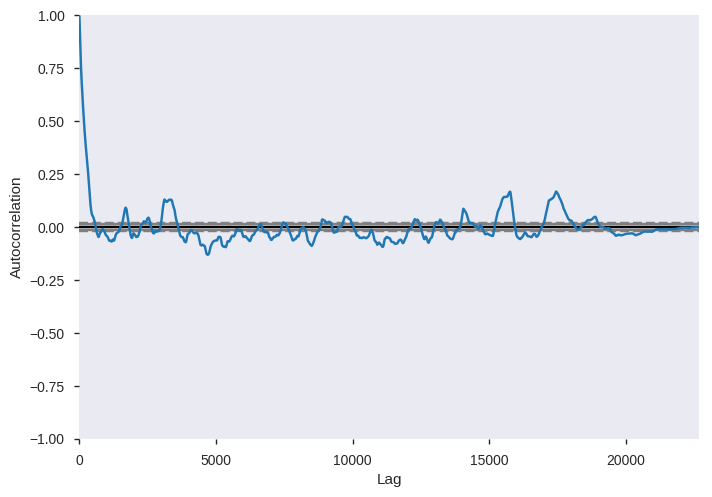

In [41]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts)

# Adding the Anomaly Score & LH

## Definitions

**Anomaly Score (AS)**:
            - 0 if current value was predicted
            - 1 if value was totally unpredicted
            - bw. 0 and 1 if similar\* to predicted value 
\* *similar after encoding; similarity in the column space*


**Anomaly LH**:
            - estimate the probability distribution of historical AS
            - compute LH that the recent AS comes from same distribution as historical AS

---
**Some Considerations:**
- `learningPeriod = 288` learning phase for TM, so that the *anomaly score* stabilizes. Ergo for the first 288 observation the LH is 0.
- The LH window `W = 8640` and the smaller window `W'=100`. The Gaussian is updated every 100 steps, .
- We are thresholding Anomaly_LH rather then AS. Why? AS would give too many **FP**, since data are noisy.    

In [164]:
# a = 380
# b = 450
# ticks = np.arange(a, b, 50)

# fig, axes = fig.subplots(3)

# plt.figure(1)
# plt.subplot(311)
# plt.plot(data.kw_energy_consumption[a:b])
# plt.title('Hotgym Anomaly Detection')
# plt.ylabel('kw_consumption')
# #plt.xticks(ticks, data.loc[ticks, ''].values)

# plt.subplot(312)
# plt.plot(data.anomaly_score.values[a:b])
# plt.ylabel('anomaly_score')
# #plt.xticks(ticks, data.loc[ticks, 'timestamp'].values)

# plt.subplot(313)
# plt.plot(data.anomaly_likelihood[a:b])
# plt.ylabel('anomaly_LH')
# plt.xlabel('time(h)')
# #plt.xticks(ticks, data.loc[ticks, 'timestamp'].values)

# plt.show()

In [87]:
anomalies_gt = ["2013-12-10 06:25:00.000000", "2013-12-12 05:35:00.000000", "2013-12-15 17:50:00.000000", 
            "2013-12-17 17:00:00.000000", "2014-01-27 14:20:00.000000", "2014-01-29 13:30:00.000000", 
            "2014-02-07 14:55:00.000000", "2014-02-09 14:05:00.000000"]

idcs = data.label[data.label==1].index

# for i in idcs[0:10]:
#     print i

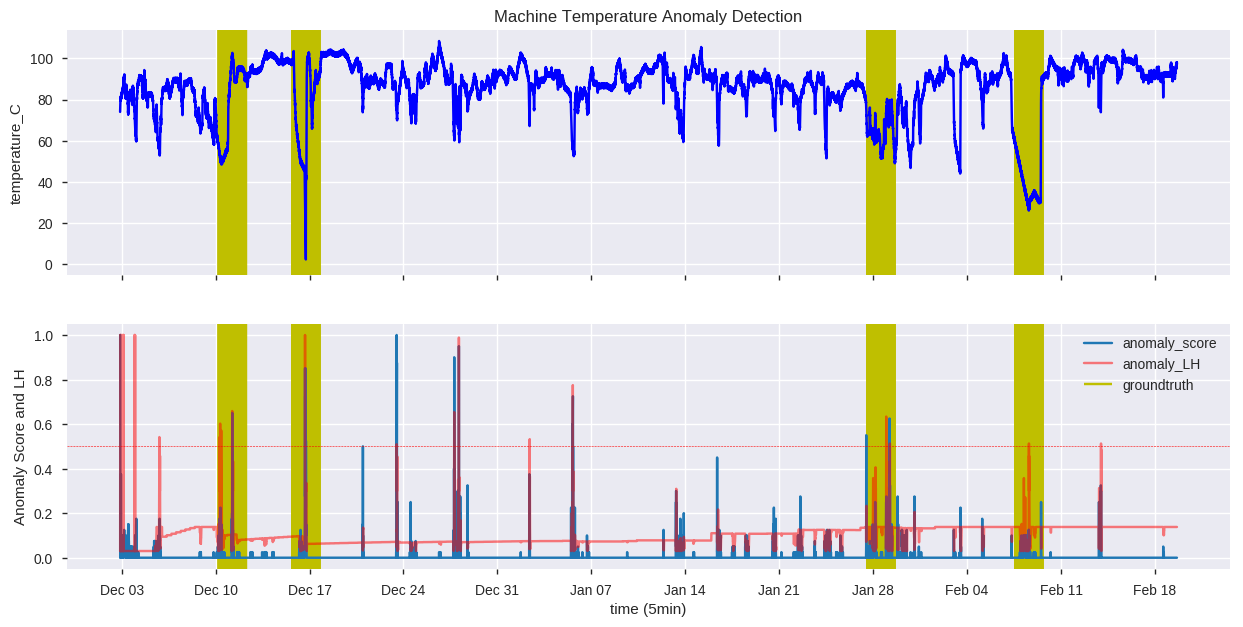

In [111]:
a = 0
b = -1

fig, ax = plt.subplots(2, sharex=True, figsize=(15,7))
ax[0].plot(data.value[a:b], color='b')
ax[0].set(ylabel='temperature_C', title='Machine Temperature Anomaly Detection')
ax[0].vlines(idcs, 0, 1, transform=ax[0].get_xaxis_transform(), colors='y')
#ax[0].vlines(anomalies_gt, 0, 1, transform=ax[0].get_xaxis_transform(), colors='b', linestyles={'dashed'})


ax[1].plot(data.raw_score[a:b], label='anomaly_score')
ax[1].set(ylabel='Anomaly Score and LH')
ax[1].plot(data.anomaly_score[a:b], color='r', alpha=0.5, label='anomaly_LH')
ax[1].axhline(y=0.5, 
              color='r', linestyle='--', linewidth=0.4)
              #xmin=data.anomaly_likelihood.index[a], xmax=data.anomaly_likelihood.index[b])
ax[1].vlines(idcs, 0, 1, transform=ax[1].get_xaxis_transform(), colors='y', label='groundtruth')
ax[1].set(xlabel='time (5min)')
ax[1].legend(loc=1)

#set ticks every week
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

Moving further in our time series, we can see that AS stabilizes (usually belove `0.2`).  
Setting the **threshold** of the log(LH) to 0.5 is equivalent to LH=0.9999.

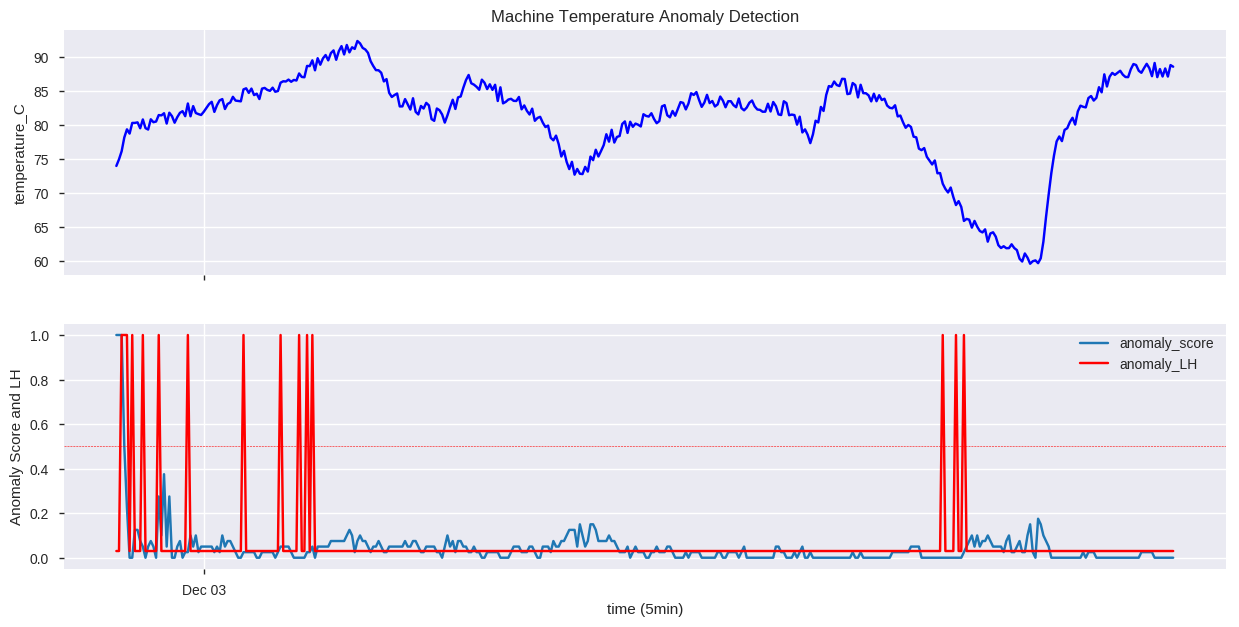

In [110]:
a = 0
b = 400

fig, ax = plt.subplots(2, sharex=True, figsize=(15,7))
ax[0].plot(data.value[a:b], color='b')
ax[0].set(ylabel='temperature_C', title='Machine Temperature Anomaly Detection')

ax[1].plot(data.raw_score[a:b], label='anomaly_score')
ax[1].set(ylabel='Anomaly Score and LH')
ax[1].plot(data.anomaly_score[a:b], color='r', label='anomaly_LH')
ax[1].axhline(y=0.5, 
              color='r', linestyle='--', linewidth=0.4)
              #xmin=data.anomaly_likelihood.index[a], xmax=data.anomaly_likelihood.index[b])
ax[1].set(xlabel='time (5min)')
ax[1].legend(loc=1)

#set ticks every week
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))